# Stock Price Prediction

In this project, we'll predict stock prices using historical data.  To do that, we'll

* Download historical stock prices from Yahoo finance
* Explore the data
* Ensure that we're predicting future prices using historical prices
* Test a machine learning model
* Setup a backtesting engine
* Add more indicators

At the end, we'll document some potential future directions we can go in.

## Setup

For the purposes of this project, we're going to assume that we want to buy stock.  But obviously we want to make money doing so!  So we only want to buy stock on days when the price will go up.  We want to create an algorithm to predict days when the price will increase.  If the algorithm says that the price will increase the next day, we'll buy stock.  If the algorithm says that the price will go down, we won't do anything.

We want to maximize our `true positives` - days when the algorithm predicts that the price will go up, and it actually goes go up.  Therefore, we'll be using precision as our error metric for our algorithm, which is `true positives / (false positives + true positives)`.  This will ensure that we correctly predict days when the price will go up.

This means that we will have to accept a lot of `false negatives` - days when we predict that the price will go down, but it actually goes up.  This is okay, though, since we'd rather ensure that on the days the algorithm predicts the price will go up, it actually does.

## Downloading the data

First, we'll download the data from Yahoo Finance.  We'll save the data after we download it, so we don't have to re-download it every time (this could cause our IP to get blocked).

In [143]:
# Import finance API and get historical stock data

import yfinance as yf
import os
import json
import pandas as pd

DATA_PATH = "msft_data.json"

if os.path.exists(DATA_PATH):
    # Read from file if we've already downloaded the data.
    with open(DATA_PATH) as f:
        msft_hist = pd.read_json(DATA_PATH)
else:
    msft = yf.Ticker("MSFT")
    msft_hist = msft.history(period="max")

    # Save file to json in case we need it later.  This prevents us from having to re-download it every time.
    msft_hist.to_json(DATA_PATH)

As we can see, we have one row of data for each day that Microsoft stock was traded.  This shows the following:

* Open - the price the stock opened at.
* High - the highest price during the day
* Low - the lowest price during the day
* Close - the closing price
* Volume - how many shares were traded

In [144]:
# Display microsoft stock price history so we can look at the structure of the data
msft_hist.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
1986-03-13,0.055898,0.064119,0.055898,0.061378,1031788800,0.0,0.0
1986-03-14,0.061378,0.064667,0.061378,0.063570,308160000,0.0,0.0
1986-03-17,0.063570,0.065215,0.063570,0.064667,133171200,0.0,0.0
1986-03-18,0.064667,0.065215,0.062474,0.063022,67766400,0.0,0.0
1986-03-19,0.063022,0.063570,0.061378,0.061926,47894400,0.0,0.0


Next, we'll plot the data so we can see how the stock price has changed over time.

<AxesSubplot:>

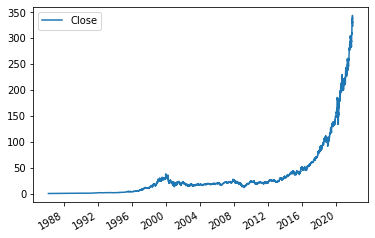

In [145]:
# Visualize microsoft stock prices
msft_hist.plot.line(y="Close", use_index=True)

## Preparing the data

Ok, hopefully you've stopped kicking yourself for not buying Microsoft stock at any point in the past 30 years now. 

Now, let's prepare the data so we can make predictions.  We'll be predicting if the price tomorrow will go up or down based on data from today.

First, we'll identify a target that we're trying to predict.  That is if the price will go up or down on a given day.  We'll code up as 1, and down as 0.

Next, we'll shift the data from previous days "forward" one day, so we can use it to predict the target price.

Then, we'll combine both so we have our training data.

In [146]:
# Setup the target we're trying to predict
data = msft_hist[["Close"]]
data = data.rename(columns = {'Close':'Actual_Close'})

# This identifies if the price went up or down
data["Target"] = msft_hist.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]

In [147]:
# Shift stock prices forward one day, so we're predicting tomorrow's stock prices from today's prices.
msft_prev = msft_hist.copy()
msft_prev = msft_prev.shift(1)

In [148]:
# Create our training data

predictors = ["Close", "Volume", "Open", "High", "Low"]
data = data.join(msft_prev[predictors]).iloc[1:]

In [149]:
data.head(5)

,Actual_Close,Target,Close,Volume,Open,High,Low
1986-03-14,0.063570,1.0,0.061378,1.031789e+09,0.055898,0.064119,0.055898
1986-03-17,0.064667,1.0,0.063570,3.081600e+08,0.061378,0.064667,0.061378
1986-03-18,0.063022,0.0,0.064667,1.331712e+08,0.063570,0.065215,0.063570
1986-03-19,0.061926,0.0,0.063022,6.776640e+07,0.064667,0.065215,0.062474
1986-03-20,0.060282,0.0,0.061926,4.789440e+07,0.063022,0.063570,0.061378


## Creating a machine learning model

Next, we'll create a machine learning model to see how accurately we can predict the stock price.

Because we're dealing with time series data, we can't just use cross-validation to create predictions for the whole dataset.  Instead, we have to use earlier data to predict later rows.

We'll start off by predicting just the last 100 rows.  We'll use a ridge regression model to generate our predictions.  This is a linear model, but one that will penalize the coefficients to prevent them from getting too large (and thus overfitting to the data).

In [150]:
from sklearn.ensemble import RandomForestClassifier

import numpy as np

# Create a random forest regression model
#model = KNeighborsClassifier(n_neighbors=500)
model = RandomForestClassifier(n_estimators=100, min_samples_split=200, random_state=1)

# Create a train and test set
train = data.iloc[:-100]
test = data.iloc[-100:]

model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=200, random_state=1)

In [151]:
# Ignore warning message from scikit-learn
import warnings
warnings.filterwarnings("ignore", lineno=156)

Next, we'll need to check how accurate the model was.  We can do this by setting up a custom function.  Our error score will be the percentage of the time that the price went in the same direction that our model thought it went.

In [152]:
from sklearn.metrics import precision_score

# Evaluate error of predictions
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.51

So our model is directionally accurate 56% of the time.  Now we can take a deeper look at the individual predictions and the actuals, and see where we're off.

<AxesSubplot:>

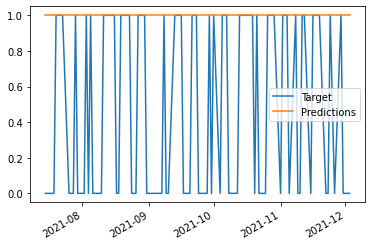

In [153]:
combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)
combined.plot()

## Backtesting

Our model isn't great, but luckily we can still improve it.  Before we do that, let's figure out how to make predictions across the entire dataset, not just the last 100 rows.

To do this, we'll need to backtest.  Backtesting ensures that we only use data from before the days that we're predicting.

Our backtesting method will loop over the dataset, and train a model every 1000 rows.

In [154]:
from sklearn.preprocessing import StandardScaler

def backtest(data, model, predictors, start=1000, step=750):
    predictions = []
    # Loop over the dataset in increments
    scaler = StandardScaler()
    for i in range(start, data.shape[0], step):
        # Split into train and test sets
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        train.loc[:,predictors] = scaler.fit_transform(train[predictors])
        test.loc[:,predictors] = scaler.transform(test[predictors])
        
        # Fit the random forest model
        model.fit(train[predictors], train["Target"])
        
        # Make predictions
        preds = model.predict_proba(test[predictors])[:,1]
        preds = pd.Series(preds, index=test.index)
        preds[preds > .6] = 1
        preds[preds<=.6] = 0
        
        # Combine predictions and test values
        combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)
        
        predictions.append(combined)
    
    return pd.concat(predictions)

In [155]:
predictions = backtest(data, model, predictors)

In [156]:
precision_score(predictions["Target"], predictions["Predictions"])

0.4930939226519337

## Improving accuracy

The model isn't very accurate, but at least now we can make predictions across the entire history of the stock.  For this model to be useful, we have to get it to predict more accurately.

Let's add some more predictors to see if we can improve accuracy.

We'll add in some rolling means, so the model can evaluate the current price against recent prices.

In [157]:
weekly_mean = data.rolling(7).mean()
quarterly_mean = data.rolling(90).mean()
annual_mean = data.rolling(365).mean()
trailing_trend = data.shift(1).rolling(7).mean()["Target"]

In [158]:
data["weekly_mean"] = weekly_mean["Close"] / data["Close"]
data["quarterly_mean"] = quarterly_mean["Close"] / data["Close"]
data["annual_mean"] = annual_mean["Close"] / data["Close"]

data["annual_weekly_mean"] = data["annual_mean"] / data["weekly_mean"]
data["annual_quarterly_mean"] = data["annual_mean"] / data["quarterly_mean"]
data["trailing_trend"] = trailing_trend

data["open_close_ratio"] = data["Open"] / data["Close"]
data["high_close_ratio"] = data["High"] / data["Close"]
data["low_close_ratio"] = data["Low"] / data["Close"]

In [159]:
full_predictors = predictors + ["weekly_mean", "quarterly_mean", "annual_mean", "annual_weekly_mean", "annual_quarterly_mean", "open_close_ratio", "high_close_ratio", "low_close_ratio"]
predictions = backtest(data.iloc[365:], model, full_predictors)

In [160]:
precision_score(predictions["Target"], predictions["Predictions"])

0.6186046511627907

<AxesSubplot:>

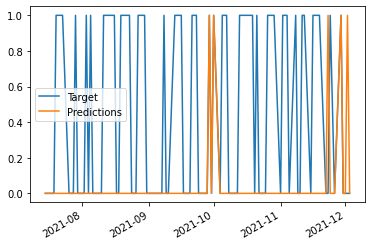

In [161]:
predictions.iloc[-100:].plot()

## Next steps

We've come 

Improve the algorithm:
* Run with a reduced step size!  This will take longer, but increase accuracy
* Try discarding older data (only keeping data in a certain window)
* Try a different machine learning algorithm


Add in more predictors
* Account for activity post-close and pre-open
    * Early trading
    * Trading on other exchanges (to see what the global sentiment is)
* Economic indicators
    * Interest rates
    * Other important economic news
* Key dates
    * Dividends
    * External factors like elections
* Company milestones
    * Earnings calls
    * Analyst ratings
* Prices of related stocks
    * Other companies in the same sector
    * Key partners, customers, etc.